In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import json
import os
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import requests
import time
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

## EDA/Data Cleaning

In [2]:
def read_files(path, filetype, num_files: int=7):
    json_files = [pos_json for pos_json in os.listdir(path) if pos_json.endswith(filetype)][:num_files]
    print(json_files)
    count = 0
    for i in json_files:
        if filetype == '.json':
            data = json.load(open(path+i))
            df = pd.DataFrame(data["playlists"])
        elif filetype=='.csv':
            df = pd.read_csv(path+i)
        
        if count==0:
            df2 = df.copy()
        else:
            df2 = pd.concat([df,df2])
        count += 1
    return(df2)

In [3]:
path = 'data/'
df = read_files(path, filetype='.json')
print(df.shape)
display(df.head())

['mpd.slice.0-999.json', 'mpd.slice.115000-115999.json', 'mpd.slice.290000-290999.json', 'mpd.slice.324000-324999.json', 'mpd.slice.596000-596999.json', 'mpd.slice.613000-613999.json', 'mpd.slice.778000-778999.json']
(7000, 12)


collaborative description  duration_ms  modified_at           name  \
0         false         NaN      7184035   1500422400          Pt. 2   
1         false         NaN      6865522   1496102400          Sober   
2          true         NaN     32671687   1463097600  Roadtrip 2016   
3         false         NaN     16690230   1448582400           Mood   
4         false         NaN      3599610   1485907200   Sunset Lover   

   num_albums  num_artists  num_edits  num_followers  num_tracks     pid  \
0          25           18         16              3          32  778000   
1          30           25          5              1          31  778001   
2         125          105         11              1         151  778002   
3          42           35          9              1          71  778003   
4          13           11          3              1          13  778004   

                                              tracks  
0  [{'pos': 0, 'artist_name': 'Rae Sremmurd', 'tr...  
1  [{'pos': 0, 'artist_name': 'Childish Gambino',...  
2  [{'pos': 0, 'artist_name': 'Thomas Rhett', 'tr...  
3  [{'pos': 0, 'artist_name': 'Halsey', 'track_ur...  
4  [{'pos': 0, 'artist_name': 'Hippie Sabotage', ...

In [4]:
df['duration_min'] = df['duration_ms']/(1000*60)

In [5]:
df['avg_dur_per_track'] = df['duration_min']/df['num_tracks']
df['avg_tracks_per_artist'] = df['num_tracks']/df['num_artists']
df['avg_tracks_per_album'] = df['num_tracks']/df['num_albums']
df['avg_tracks_per_edit'] = df['num_tracks']/df['num_edits']

In [ ]:
# Put all tracks in each playlist in the previous dataframe in a datafarame
ls = ['num_albums', 'num_artists', 'num_edits', 'num_followers', 'num_tracks', 'duration_min']
ls_avg = ['avg_dur_per_track', 'avg_tracks_per_artist', 'avg_tracks_per_album', 'avg_tracks_per_edit']

pl_cols = ls+ls_avg
df_new2 = []
count = 0
for i in range(df.shape[0]):
    d = {}
    count += len(df[['tracks']].iloc[i][0])
    for j in df[['tracks']].iloc[i][0]:
        for k in pl_cols:
            j[k] = df[[k]].iloc[i].values[0]
        #j['pos'] = i
        df_new2.append(j)
df_updated = pd.DataFrame(df_new2)

In [61]:
df_updated['duration_min'] = df_updated['duration_ms']/(1000*60)
df_updated['track_uri'] = df_updated['track_uri'].str.split(':', expand=True)[2]
df_updated['album_uri'] = df_updated['album_uri'].str.split(':', expand=True)[2]
df_updated['artist_uri'] = df_updated['artist_uri'].str.split(':', expand=True)[2]

print(df_updated.shape)
display(df_updated.head())

(67503, 18)


album_name               album_uri  \
0                                  The Cookbook  6vV5UrXcfyQD1wu4Qo2I9K   
1                                   In The Zone  0z7pVBGOD7HCIB7S8eLkLI   
2  Dangerously In Love (Alben für die Ewigkeit)  25hVFAxTlDvXbx2X2QkUkE   
3                                     Justified  6QPkyl04rXwTGlGlcYaRoW   
4                                      Hot Shot  6NmFmPX56pcLBOFMhIiKvF   

         artist_name              artist_uri  avg_dur_per_track  \
0      Missy Elliott  2wIVse2owClT7go1WT98tk           3.696287   
1     Britney Spears  26dSoYclwsYLMAKD3tpOr4           3.696287   
2            Beyoncé  6vWDO969PvNqNYHIOW5v0m           3.696287   
3  Justin Timberlake  31TPClRtHm23RisEBtV3X7           3.696287   
4             Shaggy  5EvFsr3kj42KNv97ZEnqij           3.696287   

   avg_tracks_per_album  avg_tracks_per_artist  avg_tracks_per_edit  \
0              1.106383               1.405405             8.666667   
1              1.106383               1.405405             8.666667   
2              1.106383               1.405405             8.666667   
3              1.106383               1.405405             8.666667   
4              1.106383               1.405405             8.666667   

   duration_min  duration_ms  num_albums  num_artists  num_edits  \
0      3.781050       226863          47           37          6   
1      3.313333       198800          47           37          6   
2      3.932217       235933          47           37          6   
3      4.454433       267266          47           37          6   
4      3.793333       227600          47           37          6   

   num_followers  num_tracks  pos                                  track_name  \
0              1          52    0  Lose Control (feat. Ciara & Fat Man Scoop)   
1              1          52    1                                       Toxic   
2              1          52    2                               Crazy In Love   
3              1          52    3                              Rock Your Body   
4              1          52    4                                It Wasn't Me   

                track_uri  
0  0UaMYEvWZi0ZqiDOoHU3YI  
1  6I9VzXrHxO9rA9A5euc8Ak  
2  0WqIKmW4BTrj3eJFmnCKMv  
3  1AWQoqb9bSvzTjaLralEkT  
4  1lzr43nnXAijIGYnCT8M8H

In [6]:
df_tracks = read_files(path, filetype='.csv')
df_tracks['duration_min'] = df_tracks['duration_ms']/(1000*60)
display(df_tracks.head())
display(df_tracks.describe())
display(df_tracks.dtypes)

['final_mpd_slice_0-999.csv', 'final_mpd_slice_115000-115999.csv', 'final_mpd_slice_290000-290999.csv', 'final_mpd_slice_324000-324999.csv', 'final_mpd_slice_596000-596999.csv', 'final_mpd_slice_613000-613999.csv', 'final_mpd_slice_778000-778999.csv']


album_name               album_uri   artist_name  \
0                SremmLife  6eDx949ONWDCN0O22wFZf7  Rae Sremmurd   
1                THat Part  0VZWhdLRtDPan52RfTHkp9   ScHoolboy Q   
2                Champions  1xuSorM2dDIiB5zhftB5NY    Kanye West   
3  2014 Forest Hills Drive  7viNUmZZ8ztn2UB4XB3jIL       J. Cole   
4  2014 Forest Hills Drive  7viNUmZZ8ztn2UB4XB3jIL       J. Cole   

               artist_uri  duration_ms    name  pos  \
0  7iZtZyCzp3LItcw1wtPI3D       200080   Pt. 2    0   
1  5IcR3N7QB1j6KBL8eImZ8m       288525   Pt. 2    1   
2  5K4W6rqBFWDnAN6FQUkS6x       334253   Pt. 2    2   
3  6l3HvQ5sa6mXTsMTB19rO5       239320   Pt. 2    3   
4  6l3HvQ5sa6mXTsMTB19rO5       292986   Pt. 2    4   

                      track_name               track_uri  popularity  \
0                        No Type  4scpF6J5uMBvoh6sFB7EL1        73.0   
1  THat Part - Black Hippy Remix  5sqHFfmw7MMc1L85BN8802        56.0   
2                      Champions  2nBI3iWLhupR7LyAJ5GGkE        69.0   
3                     Wet Dreamz  6Ius4TC0L3cN74HT7ENE6e        77.0   
4                 No Role Modelz  62vpWI1CHwFy7tMIcSStl8        81.0   

       ...       loudness mode  speechiness    tempo  time_signature  \
0      ...         -7.797  1.0       0.1540  125.008             4.0   
1      ...         -8.588  0.0       0.3290  112.892             4.0   
2      ...         -2.452  0.0       0.0817  135.010             4.0   
3      ...         -8.205  0.0       0.3640  175.483             4.0   
4      ...         -8.465  0.0       0.3320  100.000             4.0   

                                          track_href            type  \
0  https://api.spotify.com/v1/tracks/4scpF6J5uMBv...  audio_features   
1  https://api.spotify.com/v1/tracks/5sqHFfmw7MMc...  audio_features   
2  https://api.spotify.com/v1/tracks/2nBI3iWLhupR...  audio_features   
3  https://api.spotify.com/v1/tracks/6Ius4TC0L3cN...  audio_features   
4  https://api.spotify.com/v1/tracks/62vpWI1CHwFy...  audio_features   

                                    uri  valence  duration_min  
0  spotify:track:4scpF6J5uMBvoh6sFB7EL1    0.226      3.334667  
1  spotify:track:5sqHFfmw7MMc1L85BN8802    0.296      4.808750  
2  spotify:track:2nBI3iWLhupR7LyAJ5GGkE    0.360      5.570883  
3  spotify:track:6Ius4TC0L3cN74HT7ENE6e    0.584      3.988667  
4  spotify:track:62vpWI1CHwFy7tMIcSStl8    0.458      4.883100  

[5 rows x 29 columns]

duration_ms            pos     popularity   acousticness  \
count  4.597410e+05  459741.000000  458827.000000  459590.000000   
mean   2.345233e+05     120.562454      45.317198       0.226352   
std    6.881834e+04     199.703749      22.670717       0.272935   
min    0.000000e+00       0.000000       0.000000       0.000000   
25%    1.989070e+05      20.000000      29.000000       0.019600   
50%    2.251340e+05      49.000000      49.000000       0.100000   
75%    2.590000e+05     109.000000      64.000000       0.346000   
max    6.348017e+06     999.000000      90.000000       0.996000   

        danceability  duration_ms.1         energy  instrumentalness  \
count  459590.000000   4.595900e+05  459590.000000     459590.000000   
mean        0.607811   2.345303e+05       0.647890          0.057592   
std         0.162340   6.816821e+04       0.208496          0.189547   
min         0.000000   3.056000e+03       0.000000          0.000000   
25%         0.500000   1.989070e+05       0.515000          0.000000   
50%         0.617000   2.251470e+05       0.677000          0.000003   
75%         0.726000   2.590000e+05       0.811000          0.000833   
max         0.988000   4.466894e+06       1.000000          1.000000   

                 key       liveness       loudness           mode  \
count  459590.000000  459590.000000  459590.000000  459590.000000   
mean        5.180554       0.190280      -7.235949       0.654533   
std         3.615475       0.155759       3.625935       0.475521   
min         0.000000       0.000000     -60.000000       0.000000   
25%         2.000000       0.094600      -8.647000       0.000000   
50%         5.000000       0.126000      -6.454000       1.000000   
75%         8.000000       0.244000      -4.890000       1.000000   
max        11.000000       1.000000       2.766000       1.000000   

        speechiness          tempo  time_signature        valence  \
count  459590.00000  459590.000000   459590.000000  459590.000000   
mean        0.09720     121.560533        3.944052       0.493733   
std         0.10343      28.865703        0.332349       0.240240   
min         0.00000       0.000000        0.000000       0.000000   
25%         0.03620      99.010000        4.000000       0.302000   
50%         0.05200     120.128000        4.000000       0.488000   
75%         0.10900     140.002000        4.000000       0.682000   
max         0.96300     236.799000        5.000000       1.000000   

        duration_min  
count  459741.000000  
mean        3.908721  
std         1.146972  
min         0.000000  
25%         3.315117  
50%         3.752233  
75%         4.316667  
max       105.800283

album_name           object
album_uri            object
artist_name          object
artist_uri           object
duration_ms           int64
name                 object
pos                   int64
track_name           object
track_uri            object
popularity          float64
acousticness        float64
analysis_url         object
danceability        float64
duration_ms.1       float64
energy              float64
id                   object
instrumentalness    float64
key                 float64
liveness            float64
loudness            float64
mode                float64
speechiness         float64
tempo               float64
time_signature      float64
track_href           object
type                 object
uri                  object
valence             float64
duration_min        float64
dtype: object

## Data Exploratory/Visualization

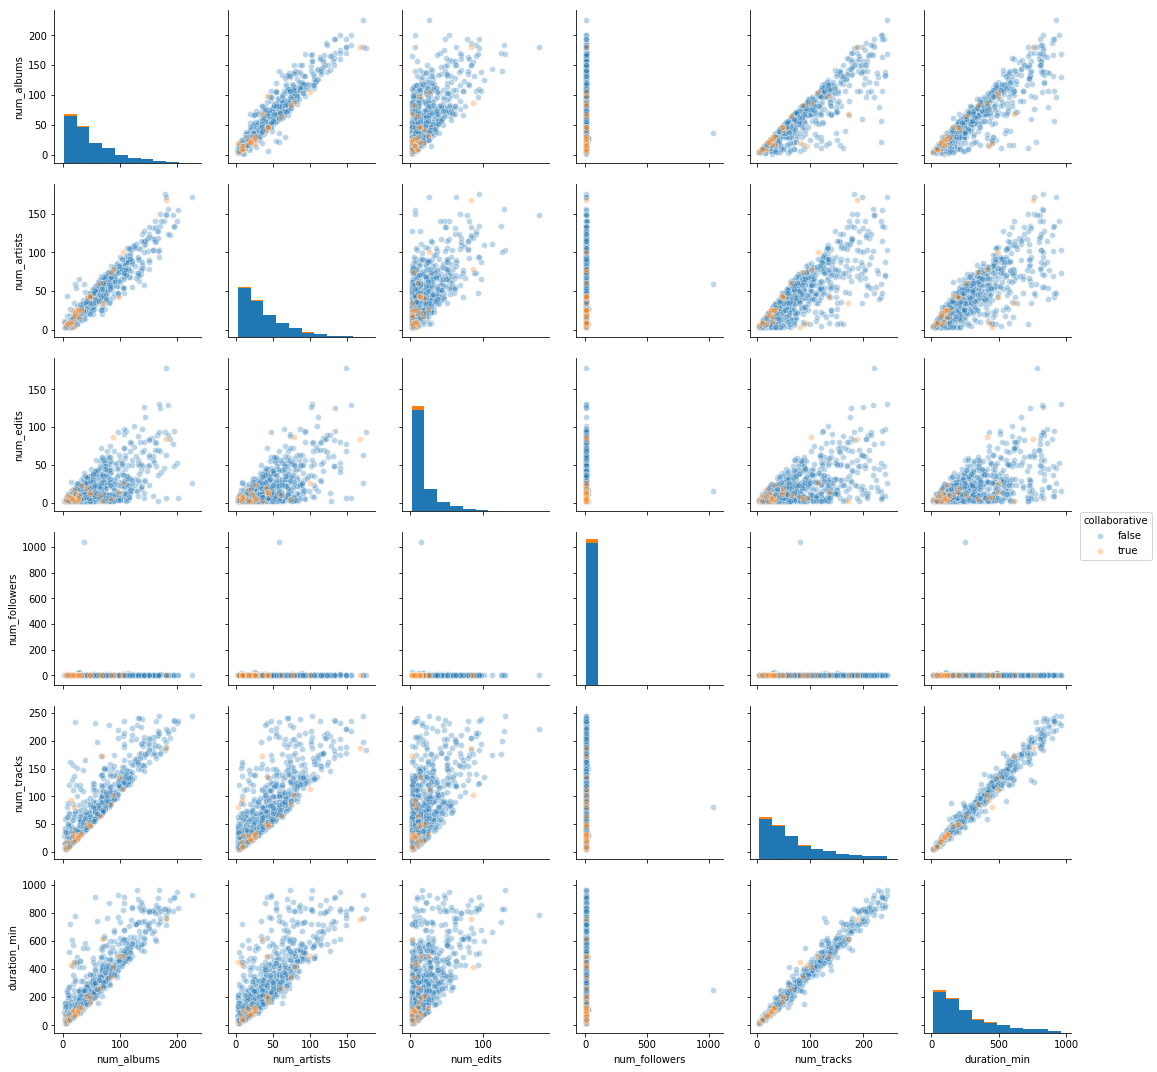

In [10]:
sns.pairplot(df[['num_albums', 'num_artists', 'num_edits', 'num_followers', 'num_tracks', 'duration_min', 'collaborative']],
            hue='collaborative', plot_kws={'alpha': 0.3})

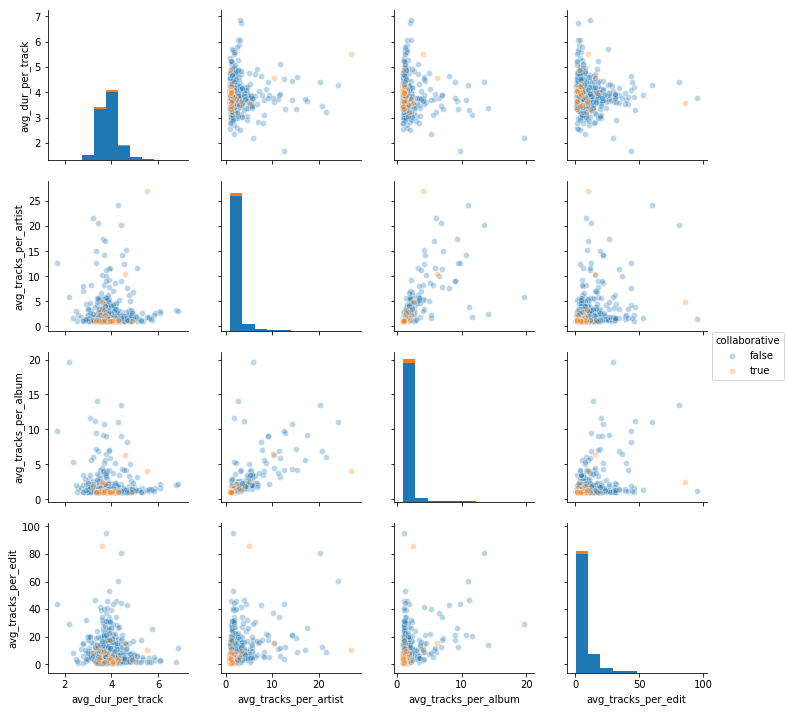

In [12]:
sns.pairplot(df[['avg_dur_per_track', 'avg_tracks_per_artist', 'avg_tracks_per_album', 'avg_tracks_per_edit', 'collaborative']], 
             hue='collaborative', plot_kws={'alpha': 0.3})

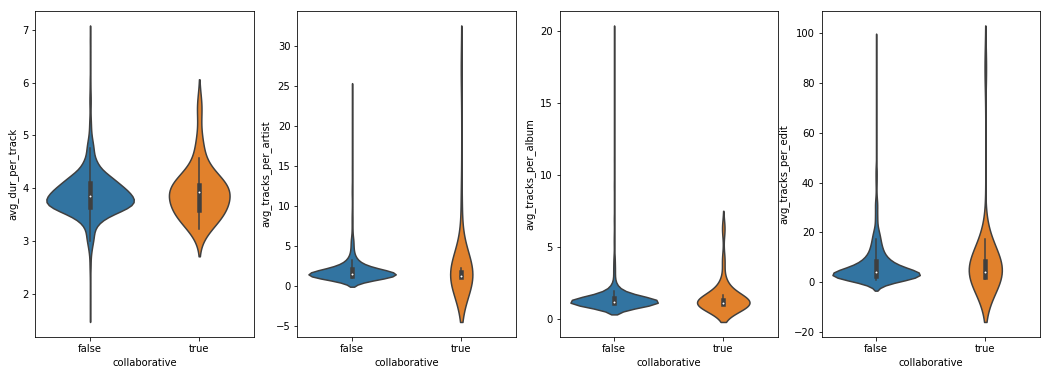

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(18,6))
for i in range(len(ls_avg)):
    sns.violinplot(x='collaborative', y=ls_avg[i], data=df, inner='box', widht=2, ax=ax[i])

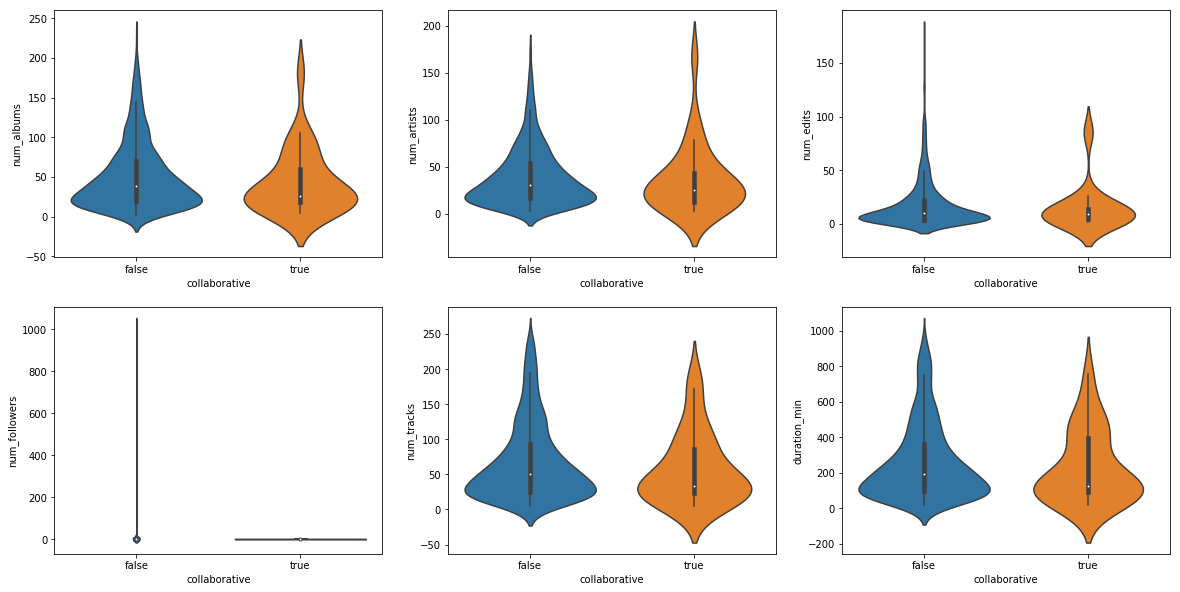

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for i in range(len(ls)):
    if i<3:
        sns.violinplot(x='collaborative', y=ls[i], data=df, inner='box', ax=ax[0, i])
    else: 
        sns.violinplot(x='collaborative', y=ls[i], data=df, inner='box', ax=ax[1, i-3])

In [63]:
df_tracks_gb = df_tracks.dropna().groupby(by=['track_uri'], as_index=False)
float_col = df_tracks.columns[(df_tracks.dtypes == 'float64')]
str_col = set(df_tracks.columns[(df_tracks.dtypes == 'object')])^set(['track_uri'])
int_col = df_tracks.columns[(df_tracks.dtypes == 'int64')]

dict_cols = {}
for i in float_col:
    dict_cols[i] = 'mean'
for i in str_col:
    dict_cols[i] = 'first'
for i in int_col:
    dict_cols[i] = 'max'

df_tracks_unique = df_tracks_gb.agg(dict_cols)

In [64]:
df_playlist_unique = pd.merge(df_updated, df_tracks_unique, how='inner', left_on='track_uri', right_on='track_uri')
df_join.head()

album_name_x             album_uri_x  artist_name_x  \
0  The Cookbook  6vV5UrXcfyQD1wu4Qo2I9K  Missy Elliott   
1  The Cookbook  6vV5UrXcfyQD1wu4Qo2I9K  Missy Elliott   
2  The Cookbook  6vV5UrXcfyQD1wu4Qo2I9K  Missy Elliott   
3  The Cookbook  6vV5UrXcfyQD1wu4Qo2I9K  Missy Elliott   
4  The Cookbook  6vV5UrXcfyQD1wu4Qo2I9K  Missy Elliott   

             artist_uri_x  avg_dur_per_track  avg_tracks_per_album  \
0  2wIVse2owClT7go1WT98tk           3.696287              1.106383   
1  2wIVse2owClT7go1WT98tk           3.787520              1.088889   
2  2wIVse2owClT7go1WT98tk           3.622344              1.053763   
3  2wIVse2owClT7go1WT98tk           4.324428              1.314961   
4  2wIVse2owClT7go1WT98tk           4.306520              1.000000   

   avg_tracks_per_artist  avg_tracks_per_edit  duration_min_x  duration_ms_x  \
0               1.405405             8.666667         3.78105         226863   
1               1.432749             9.423077         3.78105         226863   
2               1.324324            24.500000         3.78105         226863   
3               1.504505            11.133333         3.78105         226863   
4               1.076923             2.800000         3.78105         226863   

        ...        album_name_y  \
0       ...        The Cookbook   
1       ...        The Cookbook   
2       ...        The Cookbook   
3       ...        The Cookbook   
4       ...        The Cookbook   

                                        analysis_url             album_uri_y  \
0  https://api.spotify.com/v1/audio-analysis/0UaM...  6vV5UrXcfyQD1wu4Qo2I9K   
1  https://api.spotify.com/v1/audio-analysis/0UaM...  6vV5UrXcfyQD1wu4Qo2I9K   
2  https://api.spotify.com/v1/audio-analysis/0UaM...  6vV5UrXcfyQD1wu4Qo2I9K   
3  https://api.spotify.com/v1/audio-analysis/0UaM...  6vV5UrXcfyQD1wu4Qo2I9K   
4  https://api.spotify.com/v1/audio-analysis/0UaM...  6vV5UrXcfyQD1wu4Qo2I9K   

                                    uri  duration_ms_y  pos_y duration_ms.1  \
0  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI         226863     73        226864   
1  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI         226863     73        226864   
2  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI         226863     73        226864   
3  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI         226863     73        226864   
4  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI         226863     73        226864   

  key  mode  time_signature  
0   4     0               4  
1   4     0               4  
2   4     0               4  
3   4     0               4  
4   4     0               4  

[5 rows x 46 columns]

In [19]:
float_col = df_tracks_unique.columns[(df_tracks_unique.dtypes == 'float64')]
num_col = list(float_col)+['pos', 'time_signature', 'mode']

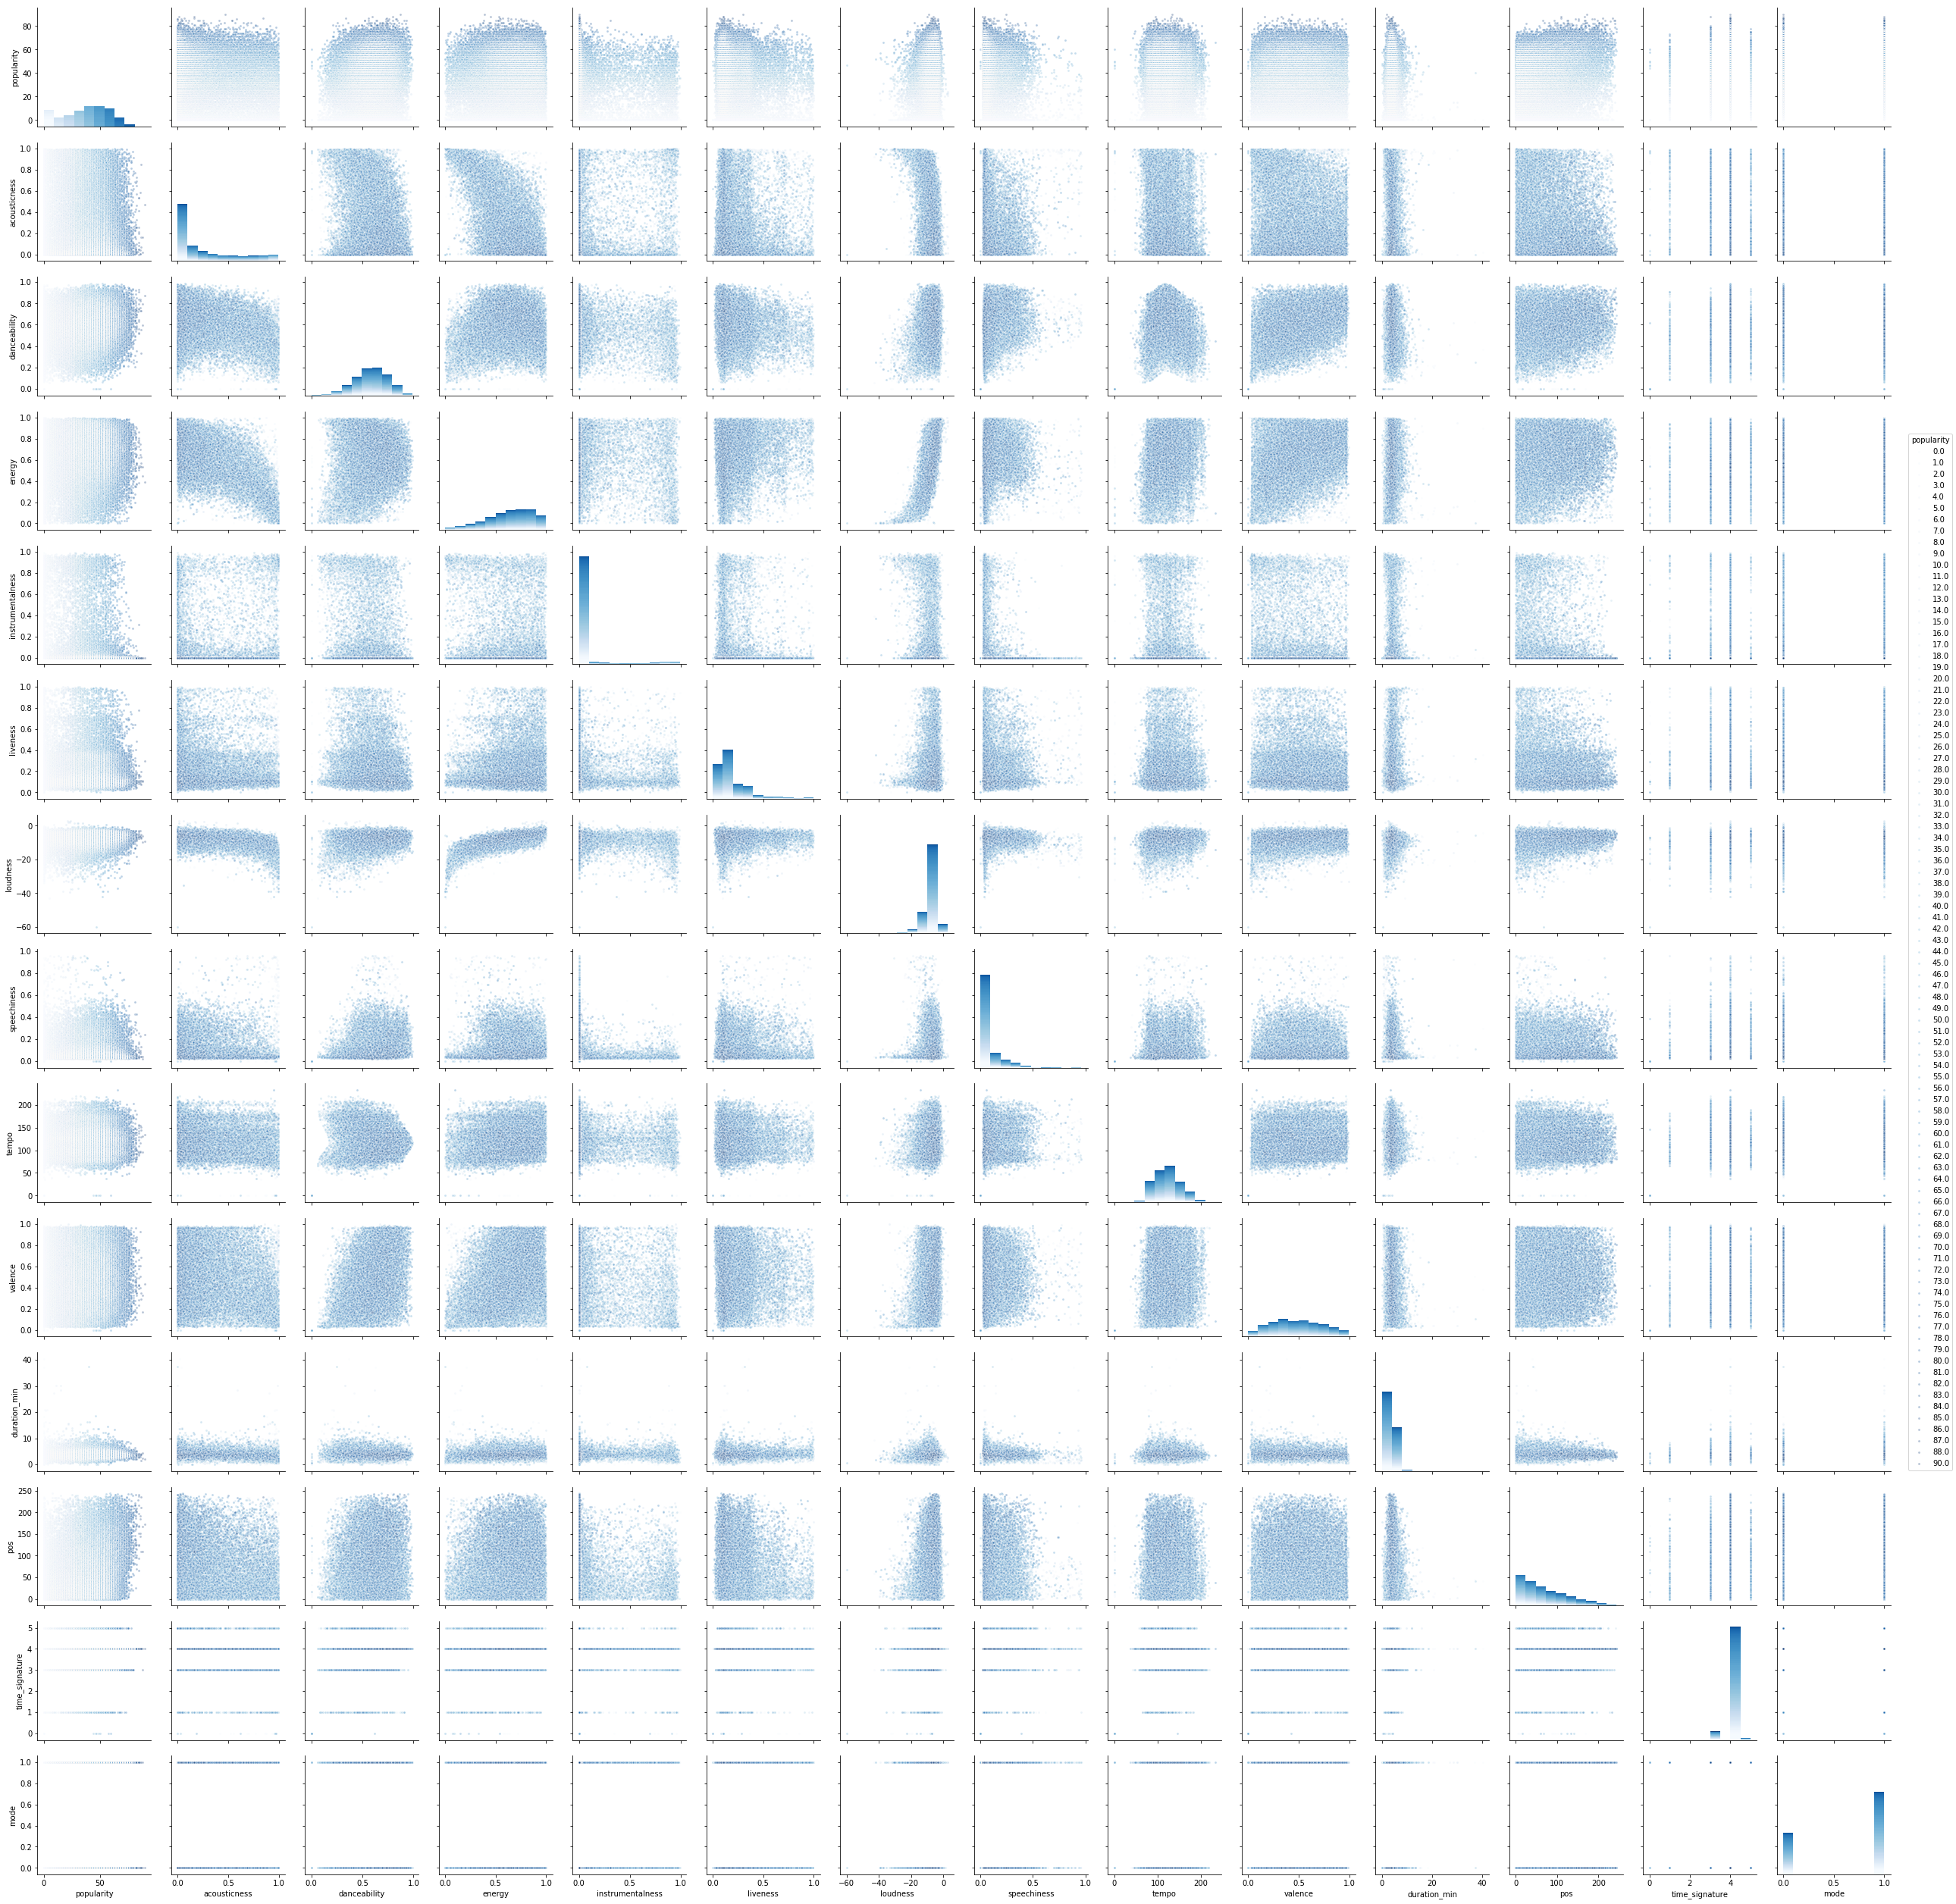

In [67]:
sns.pairplot(df_tracks_unique[num_col], markers = '.', plot_kws={'alpha': 0.3}, hue='popularity', palette='Blues')

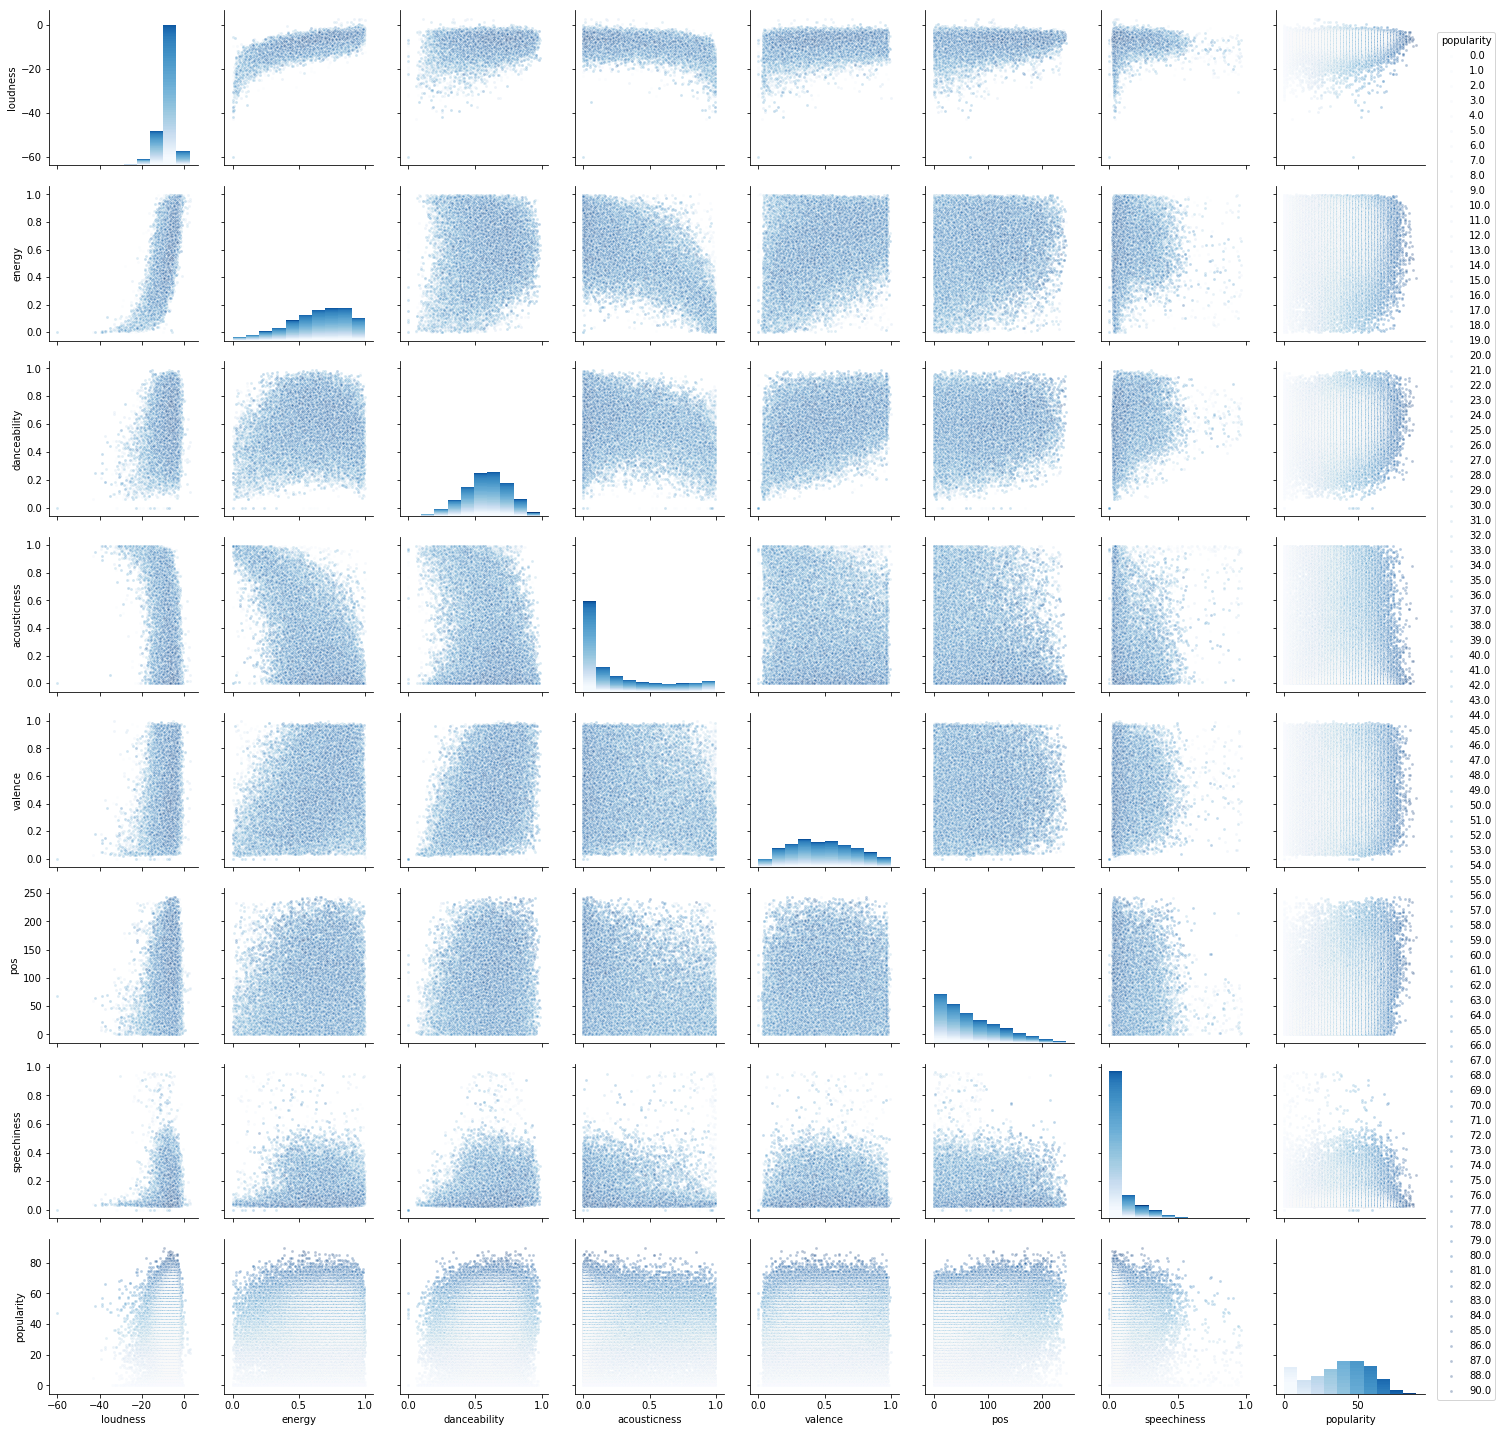

In [57]:
sns.pairplot(df_tracks_unique[['loudness', 'energy', 'danceability', 'acousticness', 'valence','pos', 'speechiness', 'popularity']],
             markers = '.', plot_kws={'alpha': 0.3}, hue='popularity', palette='Blues')

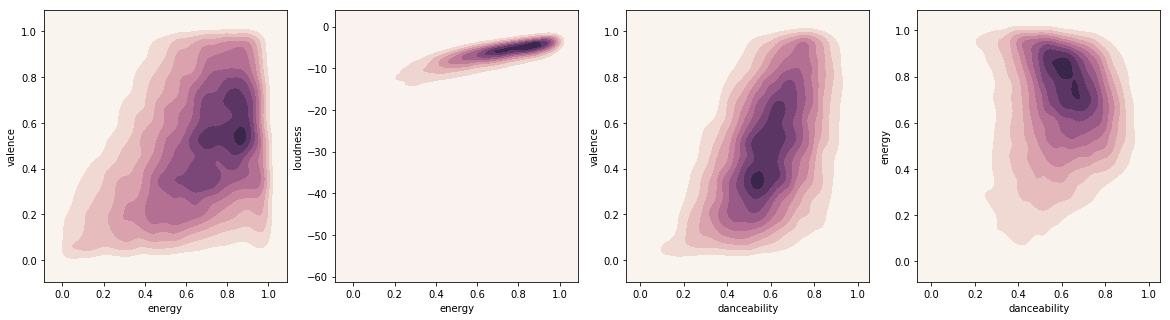

In [73]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(1, 4, figsize=(20,5))
sns.kdeplot(df_tracks_unique['energy'], df_tracks_unique['valence'], cmap=cmap, shade=True, ax=ax[0])
sns.kdeplot(df_tracks_unique['energy'], df_tracks_unique['loudness'], cmap=cmap, shade=True, ax=ax[1])
sns.kdeplot(df_tracks_unique['danceability'], df_tracks_unique['valence'], cmap=cmap, shade=True, ax=ax[2])
sns.kdeplot(df_tracks_unique['danceability'], df_tracks_unique['energy'], cmap=cmap, shade=True, ax=ax[3])

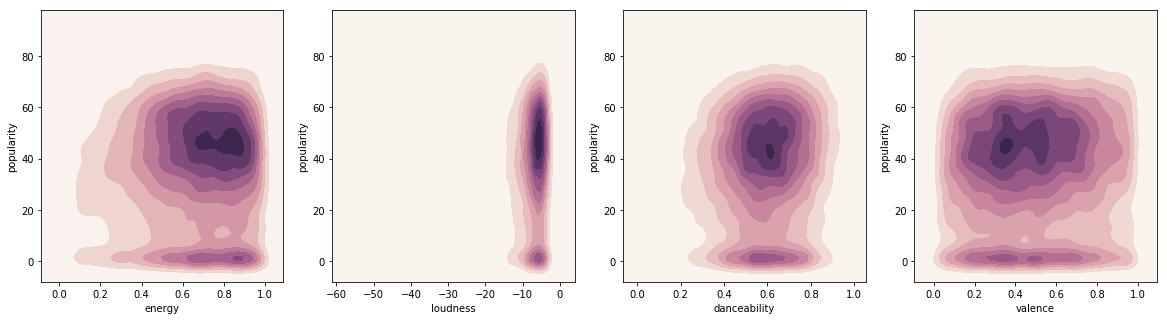

In [74]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
sns.kdeplot(df_tracks_unique['energy'], df_tracks_unique['popularity'], cmap=cmap, shade=True, ax=ax[0])
sns.kdeplot(df_tracks_unique['loudness'], df_tracks_unique['popularity'], cmap=cmap, shade=True, ax=ax[1])
sns.kdeplot(df_tracks_unique['danceability'], df_tracks_unique['popularity'], cmap=cmap, shade=True, ax=ax[2])
sns.kdeplot(df_tracks_unique['valence'], df_tracks_unique['popularity'], cmap=cmap, shade=True, ax=ax[3])

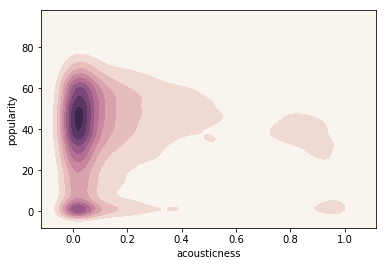

In [78]:
sns.kdeplot(df_tracks_unique['acousticness'], df_tracks_unique['popularity'], cmap=cmap, shade=True)

Text(0.5,0.91,'Distributions of Audio Features')

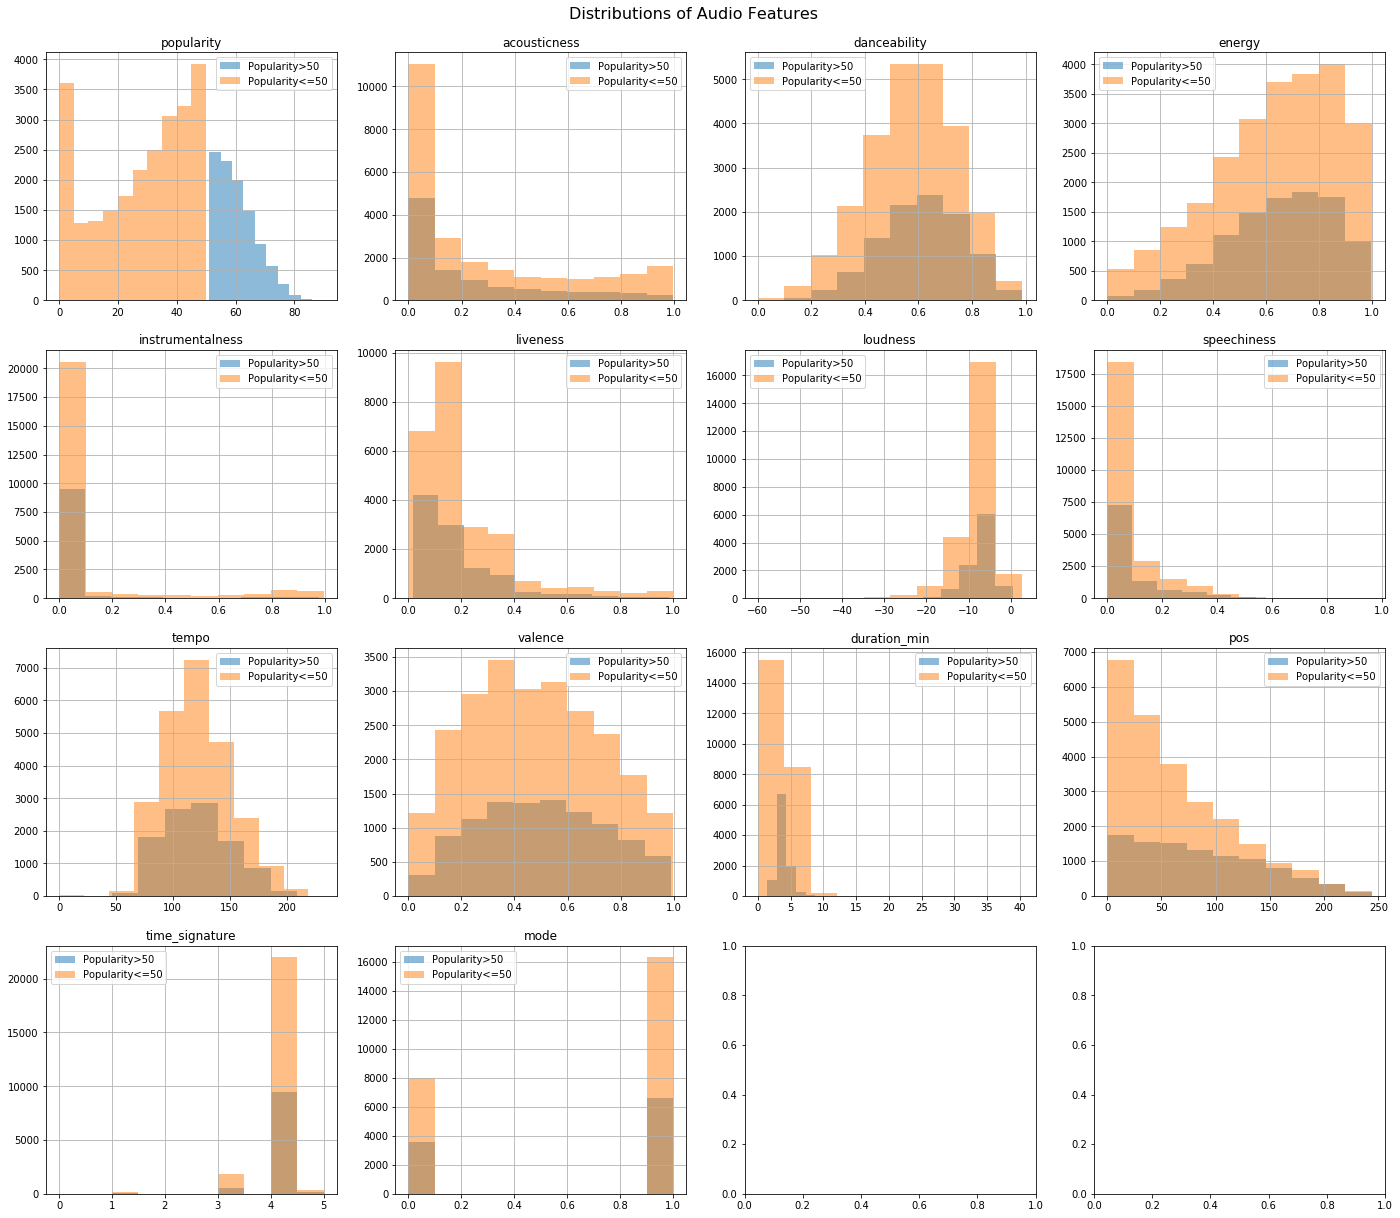

In [22]:
# plt.grid()
figure, axes = plt.subplots(4, 4, figsize=(24,21))
i=0 
j=0 
k=0
for col in num_col:
    axes[i,j].hist(df_tracks_unique[col][df_tracks_unique['popularity']>50].dropna(), label='Popularity>50', alpha=0.5)
    axes[i,j].hist(df_tracks_unique[col][df_tracks_unique['popularity']<=50].dropna(), label='Popularity<=50', alpha=0.5)
    axes[i,j].legend(loc='best')
    axes[i,j].set_title(col)
    axes[i,j].grid(b=True)
    if k in [3,7,11]: 
        i=i+1
        j=0
    else:
        j=j+1
    k=k+1
figure.suptitle('Distributions of Audio Features', y=0.91, fontsize=16)

## Base Model
*Simple Popularity Model where all playlists will get the same set of recommendations*

- Train: 6000 playlists, 460,761 tracks
- Test: 1000 playlists, 67,503 tracks

In the model, we will find the top 50 tracks from the training set. Then match these recommendations with the test playlists. The accuracy that is used by this base model is called recall. It will be measured based on the number of tracks in each playlist that are matched with the recommended 50. The accuracy will be an average among all the test playlists. It is expected that the accuracy will be very low, which reflects below with 1.572% accuracy score.

In [4]:
files = ['final_mpd_slice_290000-290999.csv', 'final_mpd_slice_324000-324999.csv', 'final_mpd_slice_422000-422999.csv', 
 'final_mpd_slice_596000-596999.csv', 'final_mpd_slice_613000-613999.csv', 'final_mpd_slice_778000-778999.csv']
tracks_train = pd.read_csv('final_mpd_slice_115000-115999.csv')
for i in files:
    temp_df = pd.read_csv(i)
    tracks_train = pd.concat([tracks_train, temp_df], ignore_index=True)
print(track_train.shape)
most_popular_track = track_train.groupby(by='track_uri')['popularity'].mean().sort_values(ascending=False).to_frame()
most_popular_track.head(50)
most_popular_track_names = []
for i in most_popular_track.head(50).index.tolist():
    most_popular_track_names.append(tracks_train.loc[tracks_train['track_uri'] == i].track_name.head(1).values[0])

(460761, 28)


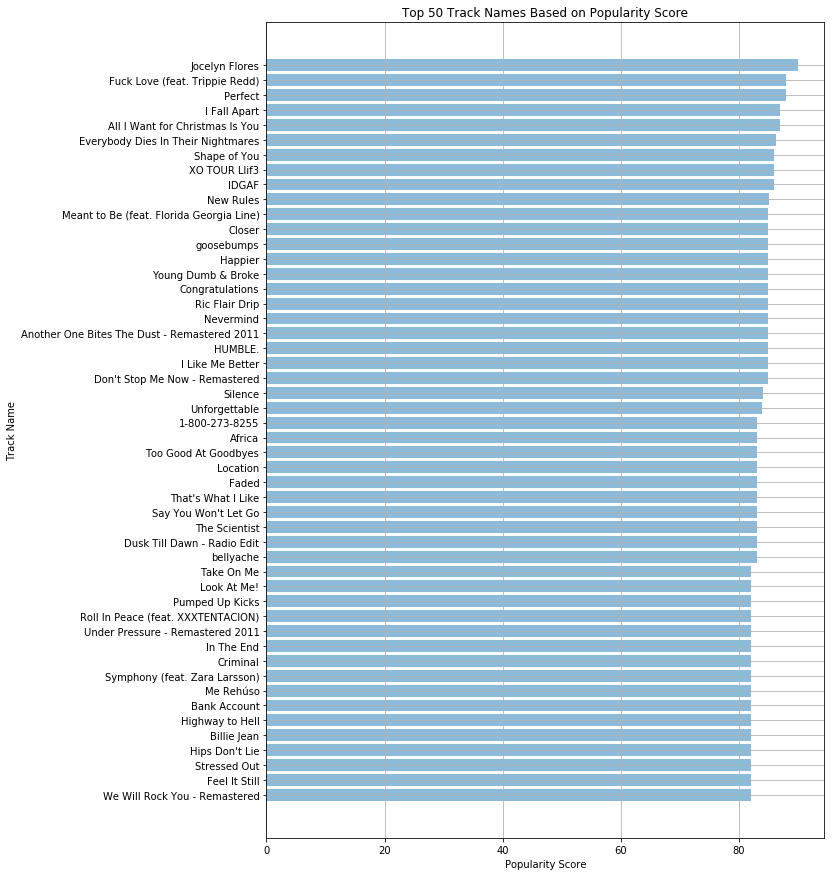

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10,15))
ax.barh(np.arange(len(most_popular_track_names)), most_popular_track.head(50).popularity.values.tolist(), 
        align='center', alpha=0.5)
ax.set_yticks(np.arange(len(most_popular_track_names)))
ax.set_yticklabels(most_popular_track_names)
ax.invert_yaxis()
plt.grid()
plt.xlabel('Popularity Score')
plt.ylabel('Track Name')
plt.title('Top 50 Track Names Based on Popularity Score')
plt.show()

In [9]:
tracks_test = pd.read_csv('final_wrongpos.csv').groupby(['pos'])['track_uri'].unique()
accuracies=[]
counts = []
for i in tracks_test:
    accuracies.append(np.intersect1d(i, np.array(most_popular_track.index[:50])))
    counts.append(len(np.intersect1d(i, np.array(most_popular_track.index[:50]))))

In [10]:
accuracy = np.average(np.array(counts)/50)
print('accuracy for the base model is', accuracy)

accuracy for the base model is 0.015719999999999998


#### Models to explore in the future - Collaborative Filter Model

In [65]:
# collaborative filter model
track_df_updated = track_df[['pos', 'track_uri', 'popularity']]
train, test = train_test_split(track_df_updated, test_size=0.3, random_state=42)
train_df = pd.DataFrame(train, columns=track_df_updated.columns.tolist())
test_df = pd.DataFrame(test, columns=track_df_updated.columns.tolist())
train_df.head()

In [66]:
#Get list of unique items
itemList=list(set(train["track_uri"].tolist()))
#Get count of users
userCount=len(set(train["pos"].tolist()))
#Create an empty data frame to store item affinity scores for items.
itemAffinity= pd.DataFrame(columns=('item1', 'item2', 'score'))
rowCount=0

#For each item in the list, compare with other items.
for ind1 in range(len(itemList)):
    
    #Get list of users who bought this item 1.
    item1Users = train[train.track_uri==itemList[ind1]]["pos"].tolist()
    #print("Item 1 ", item1Users)
    
    #Get item 2 - items that are not item 1 or those that are not analyzed already.
    for ind2 in range(ind1, len(itemList)):
        
        if ( ind1 == ind2):
            continue
       
        #Get list of users who bought item 2
        item2Users=train[train.track_uri==itemList[ind2]]["pos"].tolist()
        #print("Item 2",item2Users)
        
        #Find score. Find the common list of users and divide it by the total users.
        commonUsers= len(set(item1Users).intersection(set(item2Users)))
        score=commonUsers / userCount

        #Add a score for item 1, item 2
        itemAffinity.loc[rowCount] = [itemList[ind1],itemList[ind2],score]
        rowCount +=1
        #Add a score for item2, item 1. The same score would apply irrespective of the sequence.
        itemAffinity.loc[rowCount] = [itemList[ind2],itemList[ind1],score]
        rowCount +=1
        
#Check final result
itemAffinity.head()